# Introduction

Following the steps of the notorious Andrej Karpathy in the following video-tutorial: https://www.youtube.com/watch?v=kCc8FmEb1nY&t=1492s, in this notebook we implement a Language Model based on the Transformer architecture "from scratch" that generates sequences of words that may fool someone into thinking that they were written by Miguel de Cervantes on the mother of the novel genre: "El Quijote de la Mancha". The goal is to understand the fundamentals behind Natural Language Processing and the Transformer architecture. Being more technical, we implement and "pre-train" a Decoder-Only Transfomer to generate text using "El Quijote de la Mancha".

NOTE: The validation process and the batch creation is simplified.
- Batch creation randomly selects samples, does not take into account samples reapeated samples (within and/or outside the batch).
- Validation method: Hold Out. No Cross-validation.

# Imports

In [1]:
import torch # GOTY library
import matplotlib.pyplot as plt # Figures = Gráficas
from tqdm.auto import tqdm # Progress Bar

# Raw Data

In [2]:
# Open the file to check its content.
with open(file="el_quijote.txt", mode="r", encoding='utf-8') as f:
  text = f.read(-1)

In [3]:
# Length of the file in characters.
print(f"Length in characters: {len(text)}")

Length in characters: 1038397


In [4]:
# Quick look at the first characters.
first = 300
print(f" --- First {first} characters --- \n\n {text[:first]}")

 --- First 300 characters --- 

 DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, ada


# Tokenized Data

In [5]:
# Language Models work with tokens.
# They recieve a sequence of tokens (input) and they must return the most probable/appropriate next token (output).
# A token can be a letter, a word or even sub-word (GTP-2) ...
# In this case: token = character (keeping it easy). This kind of model it is formally called: character-level language model.
# Our model will generate character sequences that look like the Quijote.

# SO, we extract all the unique characters/tokens that our model will use from the dataset.
unique_ch = sorted(list(set(str(text))))
vocab_size = len(unique_ch)
print(unique_ch)
print(vocab_size)

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '«', '»', '¿', '̀', '́', '̃', '̈', '–', '‘', '’', '“', '”']
89


In [7]:
# Let's check an example of use of every character.

# Special attention to strange characters like: `, ´, ~ and ¨.
# These symbols transform the sound of the previous letter.
# We could think about to considering every combination letter-special symbol as a character,
# but we'll be optimistic and maybe our model learns where to place them.

# '<' is a mistake in the dataset. We must keep it for the tokenization.
for c in unique_ch:
  print(f"------------------------------------")
  print(f"Character: {list(c)}")
  print(f"Interpreted as: {c}")
  print(f"Example of use:\n{text[text.find(c)-20:text.find(c)+20]}\n")

------------------------------------
Character: ['\n']
Interpreted as: 

Example of use:
QUIJOTE DE LA MANCHA
Miguel de Cervantes

------------------------------------
Character: [' ']
Interpreted as:  
Example of use:


------------------------------------
Character: ['!']
Interpreted as: !
Example of use:
ar nombre de su dama! Y fue, a lo que se

------------------------------------
Character: ['"']
Interpreted as: "
Example of use:
na, de esta manera? "Apenas había el ru

------------------------------------
Character: ["'"]
Interpreted as: '
Example of use:
do voces, diciendo: ''Éste es el Caball

------------------------------------
Character: ['(']
Interpreted as: (
Example of use:
e Quijada o Quesada (que en esto hay alg

------------------------------------
Character: [')']
Interpreted as: )
Example of use:
 deste caso escriben), aunque por conjet

------------------------------------
Character: [',']
Interpreted as: ,
Example of use:
n lugar de la Mancha, de cuyo nombre no 


In [6]:
# Now we tokenize the dataset.

# ------ FUNCTIONS NEEDED

# Map every token (in this case a character) to an intenger.
stoi = { c:i for i,c in enumerate(unique_ch) } # string to int list
itos = { i:c for i,c in enumerate(unique_ch) } # int list to string

# Transforms string to int list
encode = lambda s: [stoi[c] for c in s]

# Transforms int list to string
decode = lambda l: ''.join([itos[i] for i in l])

# Examples of use
print("Hello World! --> ", encode("Hello World!"))
print(encode("Hello World!"), " --> ", decode(encode("Hello World!")))

Hello World! -->  [31, 56, 62, 62, 65, 1, 46, 65, 68, 62, 55, 2]
[31, 56, 62, 62, 65, 1, 46, 65, 68, 62, 55, 2]  -->  Hello World!


In [7]:
# Using PyTorch, actual tokenization of the dataset.
# Why Pytorch? It handles backpropagation, creation of dataloaders ... Automatically
tokanized_text = torch.tensor(encode(text), dtype=torch.int64)
# Tantos números como caracteres
print(tokanized_text.shape, '\n')
# Codificación y decodificación de los primeros 100.
print(tokanized_text[:100], '\n')
print(decode(tokanized_text[:100].tolist()))

torch.Size([1038397]) 

tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65]) 

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la co


# Train/Validation Split

In [8]:
# We don't want the model to memorize, better said overfit, the training data, so ...
# During the optimization process, we'll also evaluate the model (value parameters) on samples it hasn't seen, the validation set.
# If the loss function diverges for the validation set, we are overfitting the training set and we must stop.

p = 0.9 # p % train | (1-p) % validation
n = int(len(tokanized_text)*p)
train_data = tokanized_text[:n]
val_data = tokanized_text[n:]

# Manually creating Inputs and Labels

In [9]:
# Now, we manually create an inputs (sequence of tokens) and targets/labels (single token).

# The model will be feed with a sequence of tokens (block_size+1 tokens).
# From this sequence of tokens, the model will generate block_size inputs and labels to train with.
# The lenght (better known as context) of these sub-inputs will vary from 1 to block_size. This way, the transformer will learn what to generate from only one token, two tokens ...
# DO NOT confuse this group of inputs with a batch of inputs. Every sample/sequence of the batch generates block_size input/output.

# This is a toy example of a x-y (input-label) that could be feeded to the transformer.
# We also print w
block_size = 8
x = train_data[0:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
  context = x[0:t+1]
  target = y[t]
  print(f"For the input {context.tolist()}, the output is {target.tolist()}")
  print(f"For the input {decode(context.tolist())}, the output is {decode([target.tolist()])}")

For the input [27], the output is 38
For the input D, the output is O
For the input [27, 38], the output is 37
For the input DO, the output is N
For the input [27, 38, 37], the output is 1
For the input DON, the output is  
For the input [27, 38, 37, 1], the output is 40
For the input DON , the output is Q
For the input [27, 38, 37, 1, 40], the output is 44
For the input DON Q, the output is U
For the input [27, 38, 37, 1, 40, 44], the output is 32
For the input DON QU, the output is I
For the input [27, 38, 37, 1, 40, 44, 32], the output is 33
For the input DON QUI, the output is J
For the input [27, 38, 37, 1, 40, 44, 32, 33], the output is 38
For the input DON QUIJ, the output is O


In [10]:
# In the future, if the input is bigger than the maximum context length the model will ignore/forget the beggining to make its prediction. Only the last block_size tokens will be considered.
for t in range(block_size, block_size+3):
  context = train_data[(t+1)-block_size:t+1]
  target = train_data[t+1]
  print(f"Amnesia hitting hard ... For the input {context.tolist()}, the output is {target.tolist()}")
  print(f"Amnesia hitting hard ... For the input {decode(context.tolist())}, the output is {decode([target.tolist()])}")

Amnesia hitting hard ... For the input [38, 37, 1, 40, 44, 32, 33, 38], the output is 43
Amnesia hitting hard ... For the input ON QUIJO, the output is T
Amnesia hitting hard ... For the input [37, 1, 40, 44, 32, 33, 38, 43], the output is 28
Amnesia hitting hard ... For the input N QUIJOT, the output is E
Amnesia hitting hard ... For the input [1, 40, 44, 32, 33, 38, 43, 28], the output is 1
Amnesia hitting hard ... For the input  QUIJOTE, the output is  


# Manually creating a Batch

In [11]:
# Several sequences of block_size tokens (batch of sequences) are feed at the same time to the model.
# Take advantage of SBGD (Stocastic Batch Gradiente Descend).
# Squeeze the paralelization that the transformer allows.

batch_size = 4 # Number of independent sequences process on parallel
block_size = 8 # Maximun context length

def get_batch(split, batch_size):
  # Generate a batch of data of inputs x and targets y.
  # Keep in mind that this method does not care about repeated x-y.
  # The same x-y could be repeated (more than once) in the batch.
  # The same x-y could be repeated in other batch.
  if split == 'train':
    data = train_data
  else:
    data = val_data
  # Generate a random index for every input
  ix = torch.randint(len(data)-block_size, (batch_size,))
  # Generate the corresponding x and y
  x = []
  y = []
  for i in ix:
    x.append(data[i:i+block_size])
    y.append(data[i+1:i+block_size+1])
  x = torch.stack(x)
  y = torch.stack(y)

  return x, y

In [14]:
# Example
torch.manual_seed(1234)
xb, yb = get_batch('train', batch_size=4)

print('------ Inputs:')
print(xb.shape)
print(xb)
print([decode(x.tolist()) for x in xb])

print('\n------ Targets:')
print(yb.shape)
print(yb)
print([decode(t.tolist()) for t in yb])

print('\n------ What will the transformer use to train?\n')
for b in range(batch_size):
  print(f"From the {b} sequence of the batch.")
  for t in range(block_size):
    context = xb[b, 0:t+1]
    target = yb[b, t]
    print(f"For the input {context.tolist()}, the output is {target.tolist()}")
    print(f"For the input [{decode(context.tolist())}], the output is [{decode([target.tolist()])}]")
  print('')

------ Inputs:
torch.Size([4, 8])
tensor([[64, 65,  1, 52, 62,  1, 68, 71],
        [ 1, 74,  1, 67, 71, 56, 81,  1],
        [63, 71, 54, 59, 65,  1, 54, 65],
        [64, 60, 56, 68, 56, 21,  1, 66]])
['no al ru', ' y qué ', 'mucho co', 'niere; p']

------ Targets:
torch.Size([4, 8])
tensor([[65,  1, 52, 62,  1, 68, 71, 60],
        [74,  1, 67, 71, 56, 81,  1, 66],
        [71, 54, 59, 65,  1, 54, 65, 64],
        [60, 56, 68, 56, 21,  1, 66, 65]])
['o al rui', 'y qué p', 'ucho con', 'iere; po']

------ What will the transformer use to train?

From the 0 sequence of the batch.
For the input [64], the output is 65
For the input [n], the output is [o]
For the input [64, 65], the output is 1
For the input [no], the output is [ ]
For the input [64, 65, 1], the output is 52
For the input [no ], the output is [a]
For the input [64, 65, 1, 52], the output is 62
For the input [no a], the output is [l]
For the input [64, 65, 1, 52, 62], the output is 1
For the input [no al], the output is 

In [12]:
print('------ Inputs:')
print(xb.shape)
print(xb)
print([decode(x.tolist()) for x in xb])

print('\n------ Targets:')
print(yb.shape)
print(yb)
print([decode(t.tolist()) for t in yb])

------ Inputs:


NameError: name 'xb' is not defined

# First model: Biagram.

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# First, we implement one of the simplest language models: the biagram model.
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # Each token directly reads off the logits/scores for the next token from a lookup table (vocab_size logits).
        # The i-th row gives the logits of every token given the i-th token (vocab_size logits).
        # The token/column with the biggest logit/score is the one predicted next.
        # The model optimizes the values of these lookup table. On a perfectly fitted model, the ij value correspond to how often the token j follow the token i on the dataset.
        # The lookup table is matrix (vocab_size, vocad_size).
        # The maximum context of this model is 1.
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # For every token of the input, returns vocab_size values.
        # So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,C) -> (B=batch_size, T=block_size, C=vocab_size).


        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size



        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        logits = self.token_embedding_table(idx)
        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size),())
            B, T, C = logits.shape
            # Cross Entropy Loss
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))

        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Get the predictions for idx --> (B, T, C)
          logits, _ = self(idx)
          # We are only interested in the predictions (C) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, C)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, C)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Generating before training (absolute non-sense)

In [17]:
# Instantiate a model.
# Initial values for the parameters are random.
torch.manual_seed(1234)
m = BigramLanguageModel(vocab_size = vocab_size)

In [18]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx = starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0, 71, 71, 67, 80, 53, 79, 15, 35, 29, 84, 87, 60, 26, 28, 10, 35, 69,
         39, 51, 72,  5,  0, 73, 50, 10,  5, 13,  7, 46, 47,  0, 32, 38, 50, 29,
          5, 74, 63,  3, 24, 11, 35, 76,  2, 49, 47, 58, 31, 74, 51,  9, 20, 84,
         16, 40, 53,  9, 30, 17, 33, 84, 84,  4, 19, 77, 19, 45, 50, 50, 35,  3,
         81, 13, 74, 63, 48, 73, 49, 67, 25, 78, 13, 24, 66, 74, 13, 74,  3, 41,
         48, 25, 56, 29, 61, 37, 67, 75, 48, 33, 71]])
Decoded: 
uuq̀b¿5LF–“iCE0LsP]v(
x[0(3,WX
IO[F(ym"A1L¡!ZXgHy].:–6Qb.G7J––'9«9V[[L"́3ymYxZqB»3Apy3y"RYBeFjNqzYJu


### Context Length

In [19]:
# This cell tries to show that the context length of the Biagram model is 1.
# The generated tokens for every sequence of the batch is the same as the generated tokens for the last token of evey sequence.
torch.manual_seed(1234)
xb, _ = get_batch('train', batch_size=4)
torch.manual_seed(1234)
print(f'Input: \n{xb}')
print(f'Output: \n{m.generate(idx = xb, max_new_tokens=3)}')
torch.manual_seed(1234)
print(f'Input: \n{xb[:,-1:]}')
print(f'Output: \n{m.generate(idx = xb[:,-1:], max_new_tokens=3)}')

Input: 
tensor([[64, 65,  1, 52, 62,  1, 68, 71],
        [ 1, 74,  1, 67, 71, 56, 81,  1],
        [63, 71, 54, 59, 65,  1, 54, 65],
        [64, 60, 56, 68, 56, 21,  1, 66]])
Output: 
tensor([[64, 65,  1, 52, 62,  1, 68, 71, 87, 65, 71],
        [ 1, 74,  1, 67, 71, 56, 81,  1, 26,  3, 78],
        [63, 71, 54, 59, 65,  1, 54, 65, 47, 85,  4],
        [64, 60, 56, 68, 56, 21,  1, 66, 48, 50, 67]])
Input: 
tensor([[71],
        [ 1],
        [65],
        [66]])
Output: 
tensor([[71, 87, 65, 71],
        [ 1, 26,  3, 78],
        [65, 47, 85,  4],
        [66, 48, 50, 67]])


## Training

- We used the manually our homemade function to manually create batches (`get_batch(...)`).
- We estimate the model performance over the training and validation set (separatedly) once in a while (every `eval_iterval` batches) over several (`eval_batches`) batches.

In [20]:
# Hyperparameters summary
block_size = 8 # tokens per sequence feeded to the model = maximum context length
batch_size = 32 # number of sequences feeded to the model at the same time
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Validation Function

In [13]:
# Function to stimate the models performance
def estimate_loss(model, eval_iters, batch_size):
  with torch.no_grad(): # We won't call .backward() --> More efficent and quicker
    out = {}
    # Our model could behave differently training and evaluating.
    # De-activate certain layers (Dropout) or modify parameters (BatchNorm) ...
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    print(f"train_loss = {out['train']}. valid_loss = {out['val']}")
    # Back to training mode
    model.train()
  return out

### Train and Validation

  0%|          | 0/10000 [00:00<?, ?it/s]

train_loss = 4.502381801605225. valid_loss = 4.497044086456299
train_loss = 4.120266437530518. valid_loss = 4.129078388214111
train_loss = 3.797539472579956. valid_loss = 3.8077173233032227
train_loss = 3.5147008895874023. valid_loss = 3.5334525108337402
train_loss = 3.279090404510498. valid_loss = 3.2981603145599365
train_loss = 3.077587366104126. valid_loss = 3.0907840728759766
train_loss = 2.909942865371704. valid_loss = 2.9300098419189453
train_loss = 2.770601987838745. valid_loss = 2.799287796020508
train_loss = 2.665043830871582. valid_loss = 2.6926357746124268
train_loss = 2.58286714553833. valid_loss = 2.604494333267212
train_loss = 2.5121490955352783. valid_loss = 2.5371592044830322
train_loss = 2.461294651031494. valid_loss = 2.486281394958496
train_loss = 2.410219192504883. valid_loss = 2.4429516792297363
train_loss = 2.3826465606689453. valid_loss = 2.413666248321533
train_loss = 2.357506036758423. valid_loss = 2.3856430053710938
train_loss = 2.33406138420105. valid_loss = 

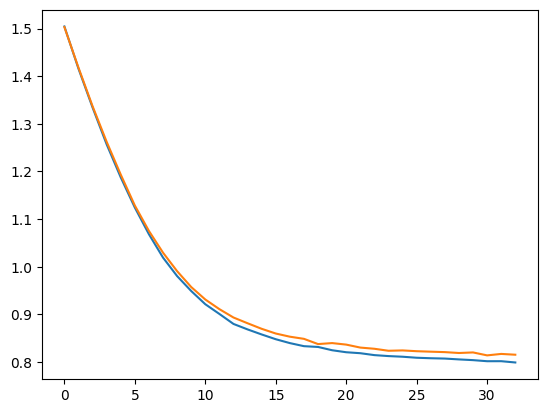

In [22]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = BigramLanguageModel(vocab_size = vocab_size)

# PyTorch optimizer.
# Uptadtes the parameters of the model during training.
# Direction of the update --> Gradient.
# Magnitude/Step of the uptade --> Learning Rate.
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [23]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 2.2227540016174316 
Validation Loss = 2.259291887283325


## Generating after training (not that much non-sense, still work to do)

In [24]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx = starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0, 48, 71, 56, 69, 54, 71, 56, 64, 70, 60, 61, 65, 69, 60, 54, 65, 69,
         66, 65, 69,  7,  1, 66, 65, 68, 65,  8,  7,  1, 55, 60, 56,  7,  1, 55,
         56, 58, 71, 56,  1, 62,  1, 66, 62, 52, 69, 60, 52,  1, 59, 65, 68, 52,
         68, 63, 53, 60, 63, 60, 54, 60, 69, 60, 61, 65, 70, 68,  1, 55, 52, 55,
         65, 64, 65, 55, 56, 68, 52, 63, 65, 69, 66, 65,  1, 74,  1, 74, 52, 64,
         58, 71, 56, 62,  1, 37, 60, 56, 64, 54, 71]])
Decoded: 
Yuescuentijosicospos, poro-, die, degue l plasia horarmbimicisijotr dadonoderamospo y yanguel Niencu


# Second Model: Starting to pay attention. Single Attention Head.

In [18]:
# Hyperparameters recap.
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time

In [19]:
# Introducing a new hyperparameter: Number of embeding dimensions.
# Internally we'll encode/transform every token to 2 vectors of 32 elements.
# --> The first identifies the token. Example: I'm an 'a'. --> token_embedding_table = nn.Embedding(vocab_size, n_embd) --> (vocab_size) possible tokens
# --> The second one identifies the position of the token. Example: I'm in third place. --> position_embedding_table = nn.Embedding(block_size, n_embd) --> (block_size) posible positions
# Finally the token will be identified by the sum of these elements.
n_embd = 32

### Attention Mecanism

In [27]:
# Self-attention!
# Note: Here token = embeded token.
# To gerate a new token, we want to consider the tokens before him, information from other tokens.
# This can be achieved by performing a weighted sum of the tokens before (remember that every token is embedded/encoded as a vector).
# The weights of this sum can be seen as how influential each token is.
# To generate these weights.
#   1. Every token generates a key (vector that represents what token is) and a query (vector that represents what it is looking for). Both are linear projections: nn.Linear(...).
#   2. Dot product of every key with every query.
# The bigger the dot product, the bigger the affinitie between the two tokens.

# Generating batch of embedded tokens ...
torch.manual_seed(1234)
B,T,C = 4,8,32 # (B,T,C) --> (B = Batch = Batch Size = Nº of sequences, T = Time = Block Size = Tokens per sequence, C = channels = Embedding Dimmensions = Dimmesion of the vector that represents the token)
x = torch.randn(B,T,C)
# For every token, T affinities will be computed. Affinities for future tokens will be set to 0 afterwards. --> (T)
# Every sequence has T tokens --> (T,T)
# There is B sequences in a batch --> (B,T,T)


# Single Head performing self-attention

head_size = 16
# Generating keys ...
# Key = What a token is? Example: A vocal on 6th position.
key = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)

# Generating queries ...
# Query = What a token is looking for? Example: A consonant prior to 4th position.
query = nn.Linear(C, head_size, bias=False)
q = query(x) # (B, T, 16)

# Computing affinities (also called attetion scores) between tokens ...
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

# No information can come from future tokens. Masking it ...
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) # Normalizing the affinities and setting future affinities from future tokens to 0

# One last detail. We do not use the raw embedded token (x, "private information") in the weighted sum. We generate a value.
# Value = What a token offers in this context.
value = nn.Linear(C, head_size, bias=False)
v = value(x) # (B, T, 16)

# Result
out = wei @ v # (B, T, T) @ (B, T, 16) ---> (B, T, 16)


out.shape

torch.Size([4, 8, 16])

In [28]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2767, 0.7233, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.7186, 0.0726, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1615, 0.0213, 0.5879, 0.2292, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0558, 0.0951, 0.1961, 0.1000, 0.5530, 0.0000, 0.0000, 0.0000],
        [0.0935, 0.6474, 0.0659, 0.0296, 0.0822, 0.0814, 0.0000, 0.0000],
        [0.0367, 0.0325, 0.0941, 0.4913, 0.2240, 0.0431, 0.0784, 0.0000],
        [0.2329, 0.2915, 0.0324, 0.1427, 0.0200, 0.0800, 0.0436, 0.1569]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights. In this case, every token of a sequence is a node pointed by all the tokens of the sequence that come before him.
- There is no notion of space. Attention simply acts over a set of vectors in a space (remember that tokens are embedded as vectors). This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other.
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling. No information from future tokens should be considered in this case (generating model), not the case for sentimient analisis.
- "Self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module). This external source of nodes that contain information that we want to be taken into consideration.
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. If Softmax saturates, only information from one token will be considered. Illustration below ...

In [29]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [30]:
print({k.var()})
print({q.var()})
print({wei.var()})

{tensor(0.9988)}
{tensor(1.0134)}
{tensor(0.9901)}


In [31]:
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1)) # gets too peaky, converges to one-hot

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


## Attenttive Model I - Single Attention Head

In [32]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Following PyTorch convetions. It is not a parameter but it is assigned to the module.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape # (B = Batch = Batch Size = Nº of sequences, T = Time = Block Size = Tokens per sequence, C = channels = Embedding Dimmensions = Dimmesion of the vector that represents the token)
        # Generating keys and querys ...
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Compute attention scores ("affinities") ...
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # No information can come from future tokens.
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # Weighted aggregation of the values (not the raw embedded token) ...
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [33]:
class FirstAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention Block
        x = self.sa_head(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [34]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.648667097091675. valid_loss = 2.671004295349121
600 iteration:
train_loss = 2.3357391357421875. valid_loss = 2.378267526626587
900 iteration:
train_loss = 2.2470860481262207. valid_loss = 2.2980692386627197
1200 iteration:
train_loss = 2.205765962600708. valid_loss = 2.264240026473999
1500 iteration:
train_loss = 2.1840310096740723. valid_loss = 2.2421164512634277
1800 iteration:
train_loss = 2.17000412940979. valid_loss = 2.2133841514587402
2100 iteration:
train_loss = 2.1691489219665527. valid_loss = 2.2159318923950195
2400 iteration:
train_loss = 2.14726185798645. valid_loss = 2.207660436630249
2700 iteration:
train_loss = 2.136218786239624. valid_loss = 2.196347951889038
3000 iteration:
train_loss = 2.1367597579956055. valid_loss = 2.192293882369995
3300 iteration:
train_loss = 2.134841203689575. valid_loss = 2.1914074420928955
3600 iteration:
train_loss = 2.1362228393554688. valid_loss = 2.1933341026306152
3900 iteration:
train_loss = 2.12764883041381

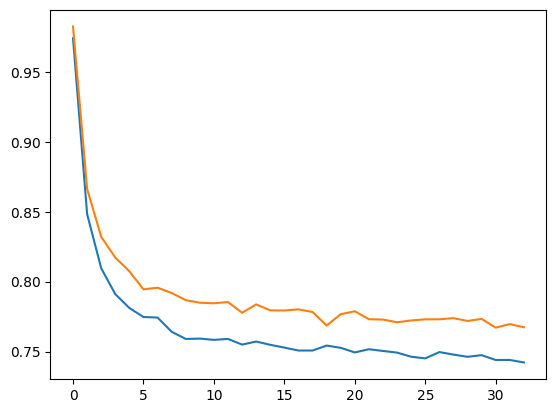

In [35]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = FirstAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [36]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 2.100595235824585 
Validation Loss = 2.1542563438415527


> Slightly better model, long way to go.

## Generating after training

In [37]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0, 48, 52,  1, 72, 56, 69, 70, 65, 62, 60, 61, 65, 68,  1, 54, 65, 69,
         66, 65, 69, 71, 60, 81,  1, 63, 65,  8,  7,  1, 55, 60, 56,  7,  1, 55,
         56, 58, 71, 64, 52,  1, 67, 71, 56,  1, 69, 71,  1, 74, 65,  7,  1, 56,
         68, 63, 60, 81, 52,  7,  1, 42, 68, 60, 61, 65, 70, 68, 65,  1, 52, 55,
         65, 64,  1, 55, 56, 68, 52, 63, 65, 69,  1, 69, 66, 60, 52, 74, 52,  1,
         58, 71, 56, 62,  1, 54, 60, 56, 64, 54, 71]])
Decoded: 
Ya vestolijor cosposuí mo-, die, deguna que su yo, ermía, Srijotro adon deramos spiaya guel ciencu


### Context Length

In [38]:
# This cell tries to show that the context length of the Biagram model is now bigger than 1.
# The generated tokens for every sequence of the batch is NOT the same as the generated tokens for the last token of evey sequence.
torch.manual_seed(1234)
xb, _ = get_batch('train', batch_size=4)
torch.manual_seed(1234)
print(f'Input: \n{xb}')
print(f'Output: \n{m.generate(idx = xb, max_new_tokens=3)}')
torch.manual_seed(1234)
print(f'Input: \n{xb[:,-1:]}')
print(f'Output: \n{m.generate(idx = xb[:,-1:], max_new_tokens=3)}')

Input: 
tensor([[64, 65,  1, 52, 62,  1, 68, 71],
        [ 1, 74,  1, 67, 71, 56, 81,  1],
        [63, 71, 54, 59, 65,  1, 54, 65],
        [64, 60, 56, 68, 56, 21,  1, 66]])
Output: 
tensor([[64, 65,  1, 52, 62,  1, 68, 71, 52, 62, 71],
        [ 1, 74,  1, 67, 71, 56, 81,  1, 70, 52,  7],
        [63, 71, 54, 59, 65,  1, 54, 65, 68,  7,  1],
        [64, 60, 56, 68, 56, 21,  1, 66, 65, 55, 56]])
Input: 
tensor([[71],
        [ 1],
        [65],
        [66]])
Output: 
tensor([[71, 69, 65, 64],
        [ 1, 70, 52,  7],
        [65, 68, 52,  1],
        [66, 65, 69, 56]])


# Third Model: More Attention. MultiHead Attention.

## Attentive Model II - MultiHead Attention

In [39]:
# Now we add weveral channels of communication, several heads in parallel.
# Each channel/head allows for a different type of information.
# --> One for vowels from the 2nd position. One for specific consonants.
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        # x --> (B,T,C)
        # h(x) --> (B,T,head_size)
        # out --> (B,T,head_size*num_heads) = (B,T,n_embd)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

In [40]:
class SecondAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.ma_head = MultiHeadAttention(num_heads=4, head_size=n_embd//4)
        # Back to vocab_size
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention Block
        x = self.ma_head(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [41]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.472409963607788. valid_loss = 2.501406669616699
600 iteration:
train_loss = 2.281641721725464. valid_loss = 2.3293416500091553
900 iteration:
train_loss = 2.2013843059539795. valid_loss = 2.256693124771118
1200 iteration:
train_loss = 2.1554036140441895. valid_loss = 2.2180402278900146
1500 iteration:
train_loss = 2.1301305294036865. valid_loss = 2.1901285648345947
1800 iteration:
train_loss = 2.1096994876861572. valid_loss = 2.152508497238159
2100 iteration:
train_loss = 2.099005699157715. valid_loss = 2.1487410068511963
2400 iteration:
train_loss = 2.0747368335723877. valid_loss = 2.1348063945770264
2700 iteration:
train_loss = 2.0605742931365967. valid_loss = 2.124903678894043
3000 iteration:
train_loss = 2.0542540550231934. valid_loss = 2.1100971698760986
3300 iteration:
train_loss = 2.0457513332366943. valid_loss = 2.102700710296631
3600 iteration:
train_loss = 2.0438807010650635. valid_loss = 2.1013011932373047
3900 iteration:
train_loss = 2.03393650

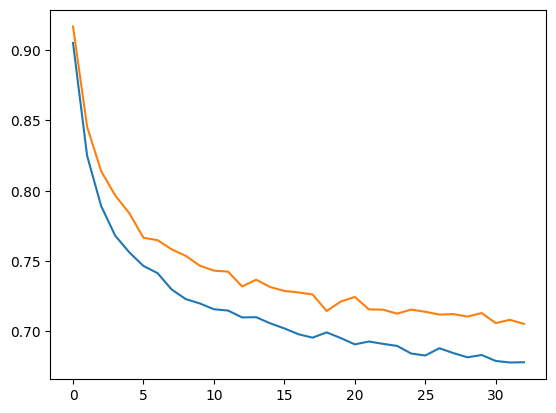

In [42]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = SecondAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [43]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 1.9701080322265625 
Validation Loss = 2.0246500968933105


> Slightly better model, long way to go.

## Generating after training

In [44]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0, 48, 71, 69,  1, 54, 71, 55, 65,  1, 66, 65, 68, 56, 81, 62, 65, 69,
          1, 55, 56,  1, 60, 81, 64,  1, 56, 69,  7,  1, 55, 60, 56, 68, 52, 68,
          1, 58, 71, 64, 52,  1, 67, 71, 56,  1, 69, 71,  1, 74, 65,  7,  1, 74,
          1, 40, 71, 60, 61, 65, 70, 68, 65,  1, 69, 56,  1, 52,  1, 53, 52, 55,
         65, 21,  1, 55, 56,  1, 74, 65,  1, 66, 52, 69, 60, 60, 53, 68, 52,  1,
         58, 71, 81, 62,  1, 54, 60, 56, 64, 70, 71]])
Decoded: 
Yus cudo porélos de ín es, dierar guna que su yo, y Quijotro se a bado; de yo pasiibra gúl cientu


# Fourth Model: More Thinking. More computation.

## Attentive Model III

In [45]:
# Now we a computation phase where every node "thinks" about the gathered data. Independently.
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        # INPUT = x --> (B,T,C)
        # OUTPUT --> (B,T,C)
        return self.net(x)

In [46]:
class ThirdAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.ma_head = MultiHeadAttention(num_heads=4, head_size=n_embd//4)
        # Thinking
        self.ffwd = FeedForward(n_embd)
        # Back to vocab_size
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention
        x = self.ma_head(x) # (B,T,C)

        # Thinking
        x = self.ffwd(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [47]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.4116125106811523. valid_loss = 2.443128824234009
600 iteration:
train_loss = 2.259600877761841. valid_loss = 2.3076581954956055
900 iteration:
train_loss = 2.1834731101989746. valid_loss = 2.2434046268463135
1200 iteration:
train_loss = 2.134544610977173. valid_loss = 2.19830322265625
1500 iteration:
train_loss = 2.1128768920898438. valid_loss = 2.1742236614227295
1800 iteration:
train_loss = 2.098580837249756. valid_loss = 2.140843391418457
2100 iteration:
train_loss = 2.081547498703003. valid_loss = 2.133807420730591
2400 iteration:
train_loss = 2.0553581714630127. valid_loss = 2.1184403896331787
2700 iteration:
train_loss = 2.0412168502807617. valid_loss = 2.113168954849243
3000 iteration:
train_loss = 2.0341434478759766. valid_loss = 2.089397430419922
3300 iteration:
train_loss = 2.0199108123779297. valid_loss = 2.0791869163513184
3600 iteration:
train_loss = 2.0204954147338867. valid_loss = 2.0741801261901855
3900 iteration:
train_loss = 2.00581932067

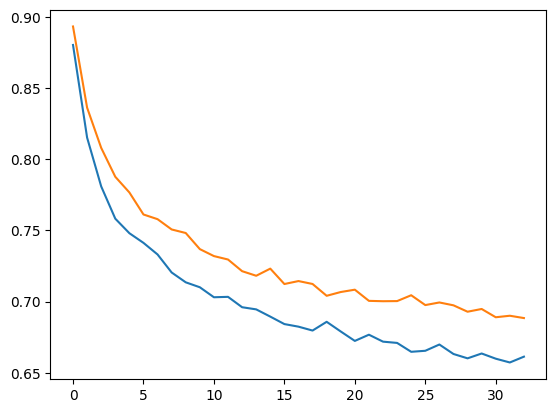

In [48]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = ThirdAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [49]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 1.9373465776443481 
Validation Loss = 1.9906009435653687


> Slightly better model, long way to go.

## Generating after training

In [50]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0, 48, 52, 64,  1, 54, 71, 55, 65, 62, 60, 61, 65, 69,  1, 54, 65, 69,
         65, 69,  1, 55, 60, 65,  1, 63, 56,  1, 62, 65, 69,  1, 55, 56,  1, 52,
         62, 58, 71, 64, 52,  1, 67, 71, 56,  1, 69, 71,  1, 66, 65, 68, 67, 71,
         56,  1, 69, 60, 63, 60,  1, 70, 68, 60, 61, 65, 70, 68, 65,  1, 52, 55,
         65, 64, 65, 55, 65,  7,  1, 67, 71, 56,  1, 69, 71, 74, 52,  1, 52,  1,
         58, 71, 56, 81,  1, 62, 52,  1, 55, 56,  1]])
Decoded: 
Yan cudolijos cosos dio me los de alguna que su porque simi trijotro adonodo, que suya a gué la de 


# Fifth Model: Deeper Model.

## Attentive Model IV

In [51]:
# Now we replicate the comunication + computation/thinking block (multihead and feedforward modules) several times to give more power to the model.
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

In [52]:
class FourthAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        # Back to vocab_size
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention + Computation
        x = self.blocks(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [53]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.9391791820526123. valid_loss = 2.9703681468963623
600 iteration:
train_loss = 2.7495901584625244. valid_loss = 2.785081148147583
900 iteration:
train_loss = 2.454596757888794. valid_loss = 2.48980975151062
1200 iteration:
train_loss = 2.357818126678467. valid_loss = 2.400665760040283
1500 iteration:
train_loss = 2.2982265949249268. valid_loss = 2.3375041484832764
1800 iteration:
train_loss = 2.2394447326660156. valid_loss = 2.285999059677124
2100 iteration:
train_loss = 2.1925277709960938. valid_loss = 2.2309021949768066
2400 iteration:
train_loss = 2.1587259769439697. valid_loss = 2.207059383392334
2700 iteration:
train_loss = 2.120483160018921. valid_loss = 2.1821393966674805
3000 iteration:
train_loss = 2.103654623031616. valid_loss = 2.167989492416382
3300 iteration:
train_loss = 2.078101873397827. valid_loss = 2.1330323219299316
3600 iteration:
train_loss = 2.072167158126831. valid_loss = 2.1160290241241455
3900 iteration:
train_loss = 2.0607120990753

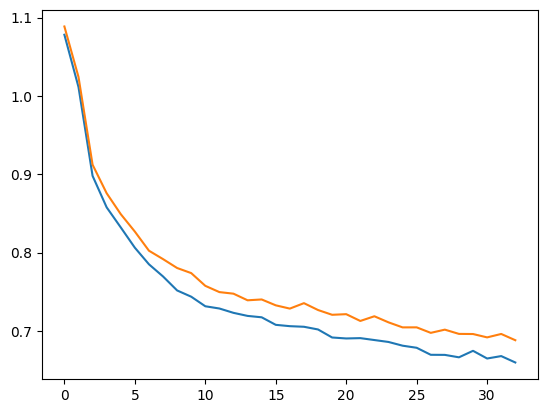

In [54]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = FourthAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [55]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 1.9341790676116943 
Validation Loss = 1.9899556636810303


> Minimun imporvent. We maybe be facing optimization problems because of a deeper model. Coming up next a couple of tricks to deal with it: residual connections and normalization.

## Generating after training

In [56]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0, 48, 71, 64,  1, 54, 71, 56, 64, 70, 60, 52, 55, 65,  1, 54, 65, 64,
         58, 65, 69,  7,  1, 66, 65, 68,  1,  8, 62, 65, 55, 60, 55, 65, 69,  7,
          1, 74,  1, 65,  1, 62, 56, 58, 60, 68, 69, 60, 65, 81,  1, 68, 60, 81,
         52, 55, 60, 81, 52,  7,  1, 42, 52, 64, 55, 65,  1, 52,  1, 53, 52, 55,
         65, 21,  1, 55, 56,  1, 74, 65,  1, 69, 71, 69,  1, 59, 60, 61, 52, 64,
         58, 56, 68, 65,  1, 54, 60, 56, 64, 70, 71]])
Decoded: 
Yun cuentiado congos, por -lodidos, y o legirsió ríadía, Sando a bado; de yo sus hijangero cientu


# Sixth Model: Residual Connections.

## Attentive Model V

In [57]:
# First trick to improve the optimization of the new deeper model: adding residual connections.
# Residual/Skip connections are gradient highways that avoid the problem of vanishing gradients.
# They allow the gradient to reach the deeper parts of the net.
# It results in a faster and more optimal optimization/training.
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        # NEW. During backprop, addition distributes the gradient signal equally
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # NEW. Project back into the residual highway
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        # x --> (B,T,C)
        # h(x) --> (B,T,head_size)
        # out --> (B,T,head_size*num_heads) = (B,T,n_embd)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # NEW. Project back into the residual highway
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd), # NEW. 4* (consult paper)
            nn.ReLU(),
            # NEW. Project back into the residual highway
            nn.Linear(4*n_embd, n_embd)
        )

    def forward(self, x):
        # INPUT = x --> (B,T,C)
        # OUTPUT --> (B,T,C)
        return self.net(x)

In [58]:
class FifthAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        # Back to vocab_size
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention + Computation
        x = self.blocks(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [59]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.213416814804077. valid_loss = 2.2552249431610107
600 iteration:
train_loss = 2.1181640625. valid_loss = 2.161328077316284
900 iteration:
train_loss = 2.0478453636169434. valid_loss = 2.1039681434631348
1200 iteration:
train_loss = 1.9943677186965942. valid_loss = 2.0485832691192627
1500 iteration:
train_loss = 1.9717764854431152. valid_loss = 2.0198287963867188
1800 iteration:
train_loss = 1.9505473375320435. valid_loss = 2.007448434829712
2100 iteration:
train_loss = 1.9290653467178345. valid_loss = 1.980472207069397
2400 iteration:
train_loss = 1.9039030075073242. valid_loss = 1.983391284942627
2700 iteration:
train_loss = 1.8924508094787598. valid_loss = 1.9477614164352417
3000 iteration:
train_loss = 1.8783117532730103. valid_loss = 1.9281964302062988
3300 iteration:
train_loss = 1.8652030229568481. valid_loss = 1.9184993505477905
3600 iteration:
train_loss = 1.8495992422103882. valid_loss = 1.899160385131836
3900 iteration:
train_loss = 1.850152850151

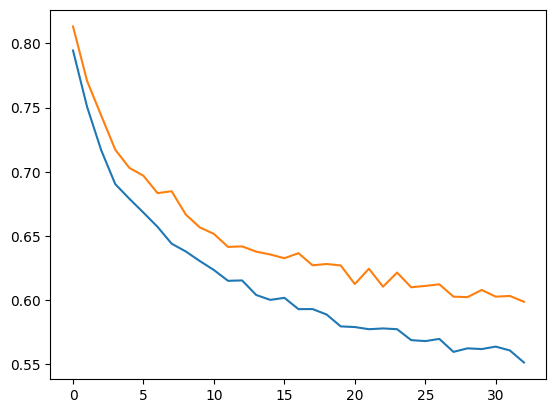

In [60]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = FifthAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [61]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 1.7355139255523682 
Validation Loss = 1.819661021232605


> Notable improvemnt. We were right.

## Generating after training

In [62]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0,  8, 26, 65, 63, 53, 71, 56, 64, 70, 56,  1, 55, 56,  1, 62, 65, 69,
          1, 55, 56, 61, 52, 68,  1, 55, 56, 69,  7,  1, 55, 60, 72, 56, 69,  7,
          1, 74,  1, 53, 52, 61, 52, 55, 65,  7,  1, 67, 71, 56,  1, 68, 60, 81,
         52, 63, 53, 60, 56, 64,  1, 70, 68, 60, 69, 57, 60, 68,  1, 55, 52, 55,
         65, 21,  1, 55, 56, 62,  1, 63, 65, 69, 70, 68, 65, 69, 60, 74, 52,  1,
         58, 71, 56, 68, 68, 52,  1, 56, 62,  1, 59]])
Decoded: 
-Combuente de los dejar des, dives, y bajado, que ríambien trisfir dado; del mostrosiya guerra el h


# Seventh Model: Normalization.

## Attentive Model VI

In [63]:
# Second optimization Trick: Add normalization layers. We normalize per token features (dim = C = 32).
# Slight deviation from original paper: layer norm before transformation (pre-nomr formulation).
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        # NEW
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = self.ln1(x) # NEW
        x = x + self.sa(x)
        x = self.ln2(x) # NEW
        x = x + self.ffwd(x)
        return x

In [64]:
class SixthAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        # Back to vocab_size
        self.ln_f = nn.LayerNorm(n_embd) # NEW. Normalizing before last transformation.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention + Computation
        x = self.blocks(x) # (B,T,C)

        # Normalizing before last transformation
        x = self.ln_f(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [65]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.258632183074951. valid_loss = 2.2911572456359863
600 iteration:
train_loss = 2.132819890975952. valid_loss = 2.178600311279297
900 iteration:
train_loss = 2.064619302749634. valid_loss = 2.1221275329589844
1200 iteration:
train_loss = 2.005725860595703. valid_loss = 2.0579049587249756
1500 iteration:
train_loss = 1.9832478761672974. valid_loss = 2.027946710586548
1800 iteration:
train_loss = 1.9584664106369019. valid_loss = 2.017725944519043
2100 iteration:
train_loss = 1.931430459022522. valid_loss = 1.9888029098510742
2400 iteration:
train_loss = 1.9055463075637817. valid_loss = 1.992719292640686
2700 iteration:
train_loss = 1.8966588973999023. valid_loss = 1.9561611413955688
3000 iteration:
train_loss = 1.876423716545105. valid_loss = 1.9403084516525269
3300 iteration:
train_loss = 1.871732234954834. valid_loss = 1.928626298904419
3600 iteration:
train_loss = 1.8539119958877563. valid_loss = 1.9079502820968628
3900 iteration:
train_loss = 1.860628008842

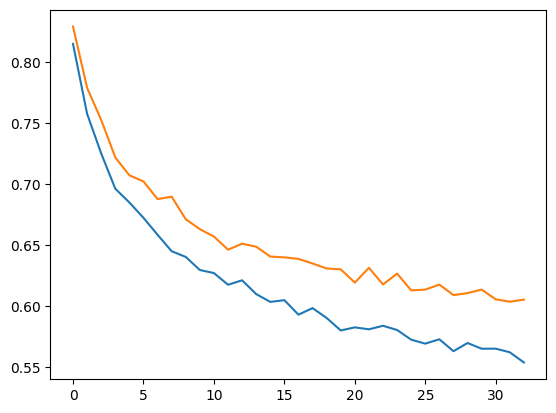

In [66]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = SixthAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [67]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 1.7394086122512817 
Validation Loss = 1.8313838243484497


> No improvement.

## Generating after training

In [68]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0,  8, 26, 65, 63, 53, 68, 56,  1, 62, 56,  1, 55, 56,  1, 62, 65, 69,
          1, 55, 56, 61, 52, 68,  1, 63, 56, 69, 62, 65, 69,  1, 55, 56, 69, 55,
         60, 58, 56, 69, 52,  1, 67, 71, 56,  1, 69, 60,  1, 66, 65, 68, 67, 71,
         56,  1, 53, 60, 56, 64,  1, 70, 68, 60, 69, 57, 65, 68, 65,  1, 52, 55,
         56, 64,  1, 55, 56, 69, 56, 63, 65, 69,  1, 69, 60,  1, 60, 64, 54, 71,
         58, 52, 68, 65, 64,  1, 67, 71, 56,  1, 59]])
Decoded: 
-Combre le de los dejar meslos desdigesa que si porque bien trisforo aden desemos si incugaron que h


# Eighth Model: Dropout.

## Attentive Model VII

In [69]:
dropout = 0.2

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [15]:
# Now we are going to try and scale the model, overfitting maybe a problem. We add dropout as a regularization technique. The model already overfitted the data so it is not a bad a idea to do it.
# Dropout: During training, every forward-backward pass, set the neuron to 0 and train without it. It can be interpreted as training an enssemble of subnetworks.
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Following PyTorch convetions. It is not a parameter but it is assigned to the module.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # NEW. Randomly avoid the communication between some tokens.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape # (B = Batch = Batch Size = Nº of sequences, T = Time = Block Size = Tokens per sequence, C = channels = Embedding Dimmensions = Dimmesion of the vector that represents the token)
        # Generating keys and querys ...
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Compute attention scores ("affinities") ...
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # No information can come from future tokens.
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # NEW. Randomly avoid the communication between some tokens.
        wei = self.dropout(wei)
        # Weighted aggregation of the values (not the raw embedded token) ...
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # Project back into the residual highway
        self.proj = nn.Linear(n_embd, n_embd)
        # NEW
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x --> (B,T,C)
        # h(x) --> (B,T,head_size)
        # out --> (B,T,head_size*num_heads) = (B,T,n_embd)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # Project back into the residual highway
        out = self.proj(out)
        # NEW
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd), # 4* (consult paper)
            nn.ReLU(),
            # Project back into the residual highway
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout), # NEW
        )

    def forward(self, x):
        # INPUT = x --> (B,T,C)
        # OUTPUT --> (B,T,C)
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        # NEW
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = self.ln1(x) # NEW
        x = x + self.sa(x)
        x = self.ln2(x) # NEW
        x = x + self.ffwd(x)
        return x

In [71]:
class SeventhAttentiveModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        # Back to vocab_size
        self.ln_f = nn.LayerNorm(n_embd) # NEW. Normalizing before last transformation.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention + Computation
        x = self.blocks(x) # (B,T,C)

        # Normalizing before last transformation
        x = self.ln_f(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

In [72]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 8 # tokens per sequence feeded to the model
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 32 # Dimension of a encoded token

# Trainig
lr=1e-3 # Learning rate
dropout = 0.2 # percentaje of neurons shutdown during training
eval_interval = 300 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/10000 [00:00<?, ?it/s]

300 iteration:
train_loss = 2.2953927516937256. valid_loss = 2.341125249862671
600 iteration:
train_loss = 2.1745119094848633. valid_loss = 2.2269694805145264
900 iteration:
train_loss = 2.1096370220184326. valid_loss = 2.1609277725219727
1200 iteration:
train_loss = 2.0733840465545654. valid_loss = 2.118849277496338
1500 iteration:
train_loss = 2.045950412750244. valid_loss = 2.0969483852386475
1800 iteration:
train_loss = 2.0175209045410156. valid_loss = 2.068509340286255
2100 iteration:
train_loss = 1.9904390573501587. valid_loss = 2.0480692386627197
2400 iteration:
train_loss = 1.9825825691223145. valid_loss = 2.044844150543213
2700 iteration:
train_loss = 1.9675050973892212. valid_loss = 2.032000780105591
3000 iteration:
train_loss = 1.9565997123718262. valid_loss = 2.0043509006500244
3300 iteration:
train_loss = 1.952291488647461. valid_loss = 1.9975756406784058
3600 iteration:
train_loss = 1.935186743736267. valid_loss = 1.9833368062973022
3900 iteration:
train_loss = 1.92832708

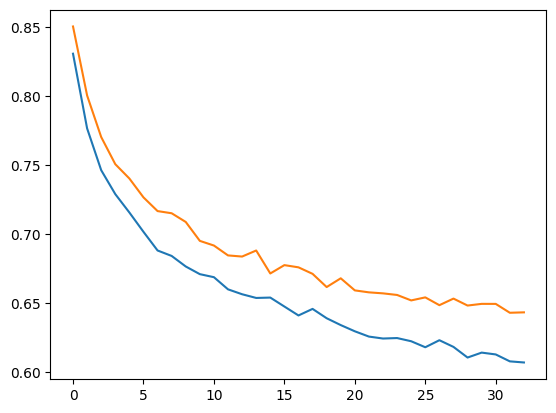

In [73]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = SeventhAttentiveModel(vocab_size = vocab_size, n_embd = 32)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

### Results

In [74]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

Train Loss = 1.8353300094604492 
Validation Loss = 1.9032020568847656


> No improvement. Less overfitting "tho".

## Generating after training

In [75]:
# Generating from 0 token (which is the '\n' character)
starting_token = torch.zeros((1, 1), dtype=torch.long)
print("---- Generating sequence from [\'\\n\']:")
torch.manual_seed(98)
generated_tokens = m.generate(idx=starting_token, max_new_tokens=100)
print(f"Encoded: {generated_tokens}")
print(f"Decoded: {decode(generated_tokens[0].tolist())}")

---- Generating sequence from ['\n']:
Encoded: tensor([[ 0,  8, 28, 64,  1, 37, 60,  1, 56, 64,  1, 62, 56, 53, 60, 65, 64, 55,
         65, 61, 71, 68, 65, 70, 56, 64,  1, 53, 56, 64, 56, 62,  1, 69, 65, 62,
         62, 56, 64, 60, 65, 81,  1, 64, 65,  1, 52,  1, 63, 56,  1, 52, 71, 64,
         70, 65,  1, 64, 56, 27, 56, 69, 54, 71, 64, 70, 68, 56,  1, 56, 64,  1,
         70, 60, 56, 64, 55, 65, 69,  1, 56, 69, 70, 52, 55, 65, 69,  7,  1, 55,
         56,  1, 74,  1, 56, 81, 62,  1, 55, 56,  1]])
Decoded: 
-En Ni en lebiondojuroten benel sollenió no a me aunto neDescuntre en tiendos estados, de y él de 


# Final Model: Scale It Up!

In [ ]:
'''# Model
vocab_size = vocab_size # number of different tokens
block_size = 256 # tokens per sequence feeded to the model
batch_size = 64 # number of sequences feeded to the model at the same time
n_embd = 384 # Dimension of a encoded token
n_head = 6 # Number of heads per multi-attention module
n_layer = 6 # Number of attention+computation blocks

# Trainig
lr=3e-4 # Learning rate
dropout = 0.2 # percentaje of neurons shutdown during training
eval_interval = 500 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 5000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu''''

In [18]:
# Hyperparameters recap.

# Model
vocab_size = vocab_size # number of different tokens
block_size = 64 # tokens per sequence feeded to the model, context length
batch_size = 32 # number of sequences feeded to the model at the same time
n_embd = 128 # Dimension of a encoded token
n_head = 4 # Number of heads per multi-attention module
n_layer = 6 # Number of attention+computation blocks

# Trainig
lr=3e-4 # Learning rate
dropout = 0.2 # percentaje of neurons shutdown during training
eval_interval = 500 # frequency of estimation of the loss (over trainig and validation)
eval_batches = 200 # number of batches used to estimate the loss (over trainig and validation)
max_iters = 10000 # number of processed batches during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
class FinalModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # Embedding Table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (V = vocab_size) possible tokens
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # (T = block_size) posible positions
        # Self-Attention Head
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # Back to vocab_size
        self.ln_f = nn.LayerNorm(n_embd) # NEW. Normalizing before last transformation.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # INPUT: idx(= batch input) and targets(=batch output) are both (B = batch_size, T = block_size) tensor of integers.
        # OUTPUT: For every token of the input, returns vocab_size values. So, vocab_size values for (batch_size, block_size) makes the dimension of the output: (B,T,V) -> (B=batch_size, T=block_size, V=vocab_size).

        #                 IDX
        #        _____________________
        #       /		                 /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Embeding the tokens and its position
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # (B = batch_size, T = block_size, C = n_embd)
        postion_emb = self.position_embedding_table(torch.arange(T)) # (T = block_size, C = n_embd)
        x = token_emb + postion_emb # (B,T,C) + (T,C) = (B,T,C) + "B*(1,T,C)" = (B,T,C) --> Broadcasting

        #                 X
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  C = range(n_embd)
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # Self-Attention + Computation
        x = self.blocks(x) # (B,T,C)

        # Normalizing before last transformation
        x = self.ln_f(x) # (B,T,C)

        # Calculating logits
        logits = self.lm_head(x) # (B,T,C) --> (B,T,v)

        #             LOGITS
        #                         ____
        #                        /___/
        #                        |   |
        #                        |   |  V = Vocab Size
        #        _______________ |___|
        #       /		            /___ /
        #      /		                /
        #   	/		                 /   B = Batch Size
        #    /		                /
        #   /____________________/
        #
        #        T = Block Size

        # When just evaluating
        if targets is None:
            loss = None
        # When training
        else:
            # Transformations "needed" for F.cross_entropy((batch_size, vocab_size), ...)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Cross Entropy Loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is the input batch tensor (B, T) of tokens.
      for _ in range(max_new_tokens):
          # Crop idx to the last block_size
          idx_crop = idx[:,-block_size:]
          # Get the predictions for idx --> (B, T, V)
          logits, _ = self(idx_crop)
          # We are only interested in the predictions (V) for the last token (-1) of every input of the batch (B).
          logits = logits[:, -1, :] # --> (B, V)
          # Apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # --> (B, V)
          # Sample the tokens using the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # Append sampled tokens to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T + 1)
      # idx is now (B, T + max_new_tokens).
      return idx

## Training

  0%|          | 0/10000 [00:00<?, ?it/s]

500 iteration:
train_loss = 2.143965721130371. valid_loss = 2.1845555305480957
1000 iteration:
train_loss = 1.9115012884140015. valid_loss = 1.9618273973464966
1500 iteration:
train_loss = 1.763418436050415. valid_loss = 1.8181935548782349
2000 iteration:
train_loss = 1.6634258031845093. valid_loss = 1.731775164604187
2500 iteration:
train_loss = 1.587068796157837. valid_loss = 1.6557328701019287
3000 iteration:
train_loss = 1.5314719676971436. valid_loss = 1.6239566802978516
3500 iteration:
train_loss = 1.493888020515442. valid_loss = 1.573530673980713
4000 iteration:
train_loss = 1.4537732601165771. valid_loss = 1.5380669832229614
4500 iteration:
train_loss = 1.4227970838546753. valid_loss = 1.5143980979919434
5000 iteration:
train_loss = 1.4015188217163086. valid_loss = 1.4911341667175293
5500 iteration:
train_loss = 1.3850395679473877. valid_loss = 1.4795992374420166
6000 iteration:
train_loss = 1.3615639209747314. valid_loss = 1.4639443159103394
6500 iteration:
train_loss = 1.3511

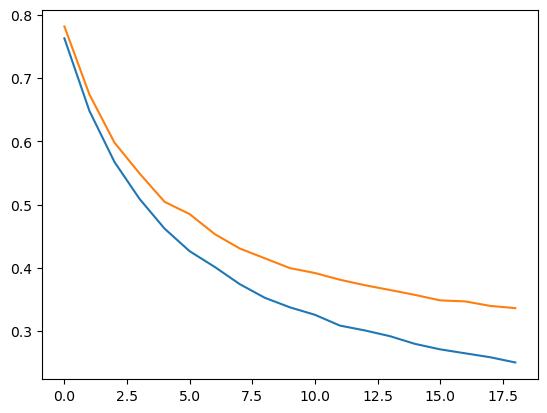

In [27]:
# Re-creating model to get random intial values for the parameters
torch.manual_seed(1234)
m = FinalModel(vocab_size = vocab_size, n_embd = n_embd)

# PyTorch optimizer.
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)


# Training loop
train_loss = [] # i-th item = estimated loss over training set after eval_interval processed batches
val_loss = [] # i-th item = estimated loss over validation set after eval_interval processed batches
for i in tqdm(range(max_iters)):

    # Fitting phase
    # Sample a batch of data
    X, Y = get_batch('train', batch_size=batch_size)
    # Evaluate the loss
    batch_logits, batch_loss = m(X, Y)
    # Backpropagate the gradient
    optimizer.zero_grad(set_to_none=True) # they add-up if kept
    batch_loss.backward()
    # Optimize the parameters
    optimizer.step()

    # Evaluating phase
    if i >= eval_interval and i % eval_interval == 0:
      print(f'{i} iteration:')
      losses = estimate_loss(model=m, eval_iters=eval_interval, batch_size=batch_size)
      train_loss.append(losses['train'])
      val_loss.append(losses['val'])

# Show results
plt.plot(torch.tensor(train_loss).log()) # .log() Makes the visualization easier
plt.plot(torch.tensor(val_loss).log())
plt.show()

In [28]:
torch.save(m.state_dict(), 'best_model_quijote')

In [ ]:
m.load_state_dict(torch.load('best_model_quijote'))

### Results

In [ ]:
print(f'Train Loss = {train_loss[-1].item()} \nValidation Loss = {val_loss[-1].item()}')

> ...

## Generating after training

In [20]:
m = FinalModel(vocab_size = vocab_size, n_embd = n_embd)
m.load_state_dict(torch.load('best_model_quijote'))

<All keys matched successfully>

In [62]:
# Generating from 0 token (which is the '\n' character)
print("---- Generating sequence from [\'\\n\']:")
starting_token = torch.zeros((1, 1), dtype=torch.long)
torch.manual_seed(98)
while True:
  generated_tokens = m.generate(idx=starting_token, max_new_tokens=1)
  starting_token = generated_tokens
  # display.clear_output(wait=True)
  # display.display(decode(generated_tokens[0].tolist()))
  print(decode(generated_tokens[0].tolist())[-1], end='')

---- Generating sequence from ['\n']:
gota hacer, le se dije está cara, por toda lo cual me hacía de con otra de mi durgor; por detantáncias dijo a la calanza, y que veo a vualego el deseño que los tomagas, males de los tocas prear estigender es cruel de la cueña de algún apórejas por don vuele de los armado de la Camila que los de don Femando le y de igualada? Alma diéndolos; costo nuestro camades. Si mal soldad dicele cualque yo no me sepas de lo que alguno había vuestra graciosa malquina que la obra, pues ayudar vos a sus sacorenta quitásemos, por la ley le bien llegar dijo:
-Capula y lleval recogación; ¿quiéndolos; que vino restreche.
-¿Qué más daga bastaltar un casto -dijo Doroteado-.
-¿No pudiese polva, salía, sin pallabre, don Quijote, en otro por dí gusto corto arrogó y espejando finada, que ni acose piedra, y cuidada cómánda menos ha correnado y gración por padre; y emperdearamos dás el amor de escuderido; que sin valleros a lo venir y destallabarle esto c

KeyboardInterrupt: 

In [65]:
print(decode(generated_tokens[0].tolist()))


gota hacer, le se dije está cara, por toda lo cual me hacía de con otra de mi durgor; por detantáncias dijo a la calanza, y que veo a vualego el deseño que los tomagas, males de los tocas prear estigender es cruel de la cueña de algún apórejas por don vuele de los armado de la Camila que los de don Femando le y de igualada? Alma diéndolos; costo nuestro camades. Si mal soldad dicele cualque yo no me sepas de lo que alguno había vuestra graciosa malquina que la obra, pues ayudar vos a sus sacorenta quitásemos, por la ley le bien llegar dijo:
-Capula y lleval recogación; ¿quiéndolos; que vino restreche.
-¿Qué más daga bastaltar un casto -dijo Doroteado-.
-¿No pudiese polva, salía, sin pallabre, don Quijote, en otro por dí gusto corto arrogó y espejando finada, que ni acose piedra, y cuidada cómánda menos ha correnado y gración por padre; y emperdearamos dás el amor de escuderido; que sin valleros a lo venir y destallabarle esto cuando entre afrenezcar,
senla una loc